# Stock Market Analysis of Multiple companies using yfinance

# Group 8: 
Gaurisha,ggaurish@depaul.edu,2115939

Priyanka Allu, sallu@depaul.edu,2115204

Lavanaya Venigal,Lvenigal@depaul.edu,2111148

In [ ]:
Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model  # GARCH modeling
from statsmodels.tsa.vector_ar.var_model import VAR  # VAR modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from scipy.stats import pearsonr
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import shap  # Feature importance
from statsmodels.tsa.seasonal import seasonal_decompose
from transformers import TFAutoModel  # For Transformer models if required

Load Data using yfinance
Description: Load stock data for Apple, Tesla, Microsoft, Amazon, and Google for the specified date range (2020-2023).

In [2]:
tickers = ["AAPL", "TSLA", "MSFT", "AMZN", "GOOGL"]
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")
data = data['Close']
print("Data Collected:\n", data.head())


[*********************100%***********************]  5 of 5 completed

Data Collected:
 Ticker                          AAPL       AMZN      GOOGL        MSFT  \
Date                                                                     
2020-01-02 00:00:00+00:00  75.087502  94.900497  68.433998  160.619995   
2020-01-03 00:00:00+00:00  74.357498  93.748497  68.075996  158.619995   
2020-01-06 00:00:00+00:00  74.949997  95.143997  69.890503  159.029999   
2020-01-07 00:00:00+00:00  74.597504  95.343002  69.755501  157.580002   
2020-01-08 00:00:00+00:00  75.797501  94.598503  70.251999  160.089996   

Ticker                          TSLA  
Date                                  
2020-01-02 00:00:00+00:00  28.684000  
2020-01-03 00:00:00+00:00  29.534000  
2020-01-06 00:00:00+00:00  30.102667  
2020-01-07 00:00:00+00:00  31.270666  
2020-01-08 00:00:00+00:00  32.809334  


Data Cleaning: Handle missing values and ensure data consistency.

In [3]:
data.fillna(method='ffill', inplace=True)
print("Data after cleaning:\n", data.head())

Data after cleaning:
 Ticker                          AAPL       AMZN      GOOGL        MSFT  \
Date                                                                     
2020-01-02 00:00:00+00:00  75.087502  94.900497  68.433998  160.619995   
2020-01-03 00:00:00+00:00  74.357498  93.748497  68.075996  158.619995   
2020-01-06 00:00:00+00:00  74.949997  95.143997  69.890503  159.029999   
2020-01-07 00:00:00+00:00  74.597504  95.343002  69.755501  157.580002   
2020-01-08 00:00:00+00:00  75.797501  94.598503  70.251999  160.089996   

Ticker                          TSLA  
Date                                  
2020-01-02 00:00:00+00:00  28.684000  
2020-01-03 00:00:00+00:00  29.534000  
2020-01-06 00:00:00+00:00  30.102667  
2020-01-07 00:00:00+00:00  31.270666  
2020-01-08 00:00:00+00:00  32.809334  


/var/folders/_9/12tkftqn7lg31ymjdhtwgts00000gn/T/ipykernel_87034/4199496447.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Basic EDA: Perform summary statistics to understand data distribution.

In [4]:
eda_summary = data.describe()
print("Summary Statistics:\n", eda_summary)

Summary Statistics:
 Ticker        AAPL        AMZN       GOOGL        MSFT        TSLA
count   756.000000  756.000000  756.000000  756.000000  756.000000
mean    130.311812  142.455482  104.257655  245.860939  206.365502
std      30.566496   27.856019   26.472870   47.582265   95.856975
min      56.092499   81.820000   52.706501  135.419998   24.081333
25%     115.739374  118.337875   78.220125  212.474998  138.270828
50%     135.379997  154.467499  104.272999  245.144997  223.651665
75%     150.704998  164.633247  126.982876  283.737495  276.565002
max     182.009995  186.570496  149.838501  343.109985  409.970001


Trend Visualization: Visualize stock price trends over time.

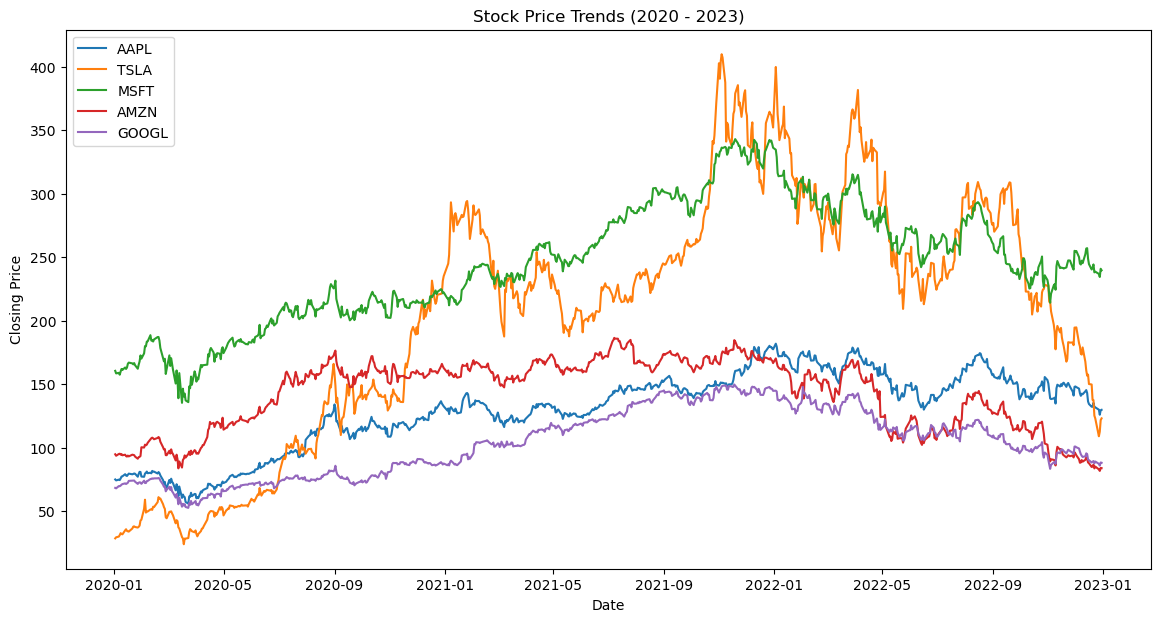

In [5]:
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)
plt.title("Stock Price Trends (2020 - 2023)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc="upper left")
plt.show()

Moving Average & Volatility Analysis: Calculate rolling means and volatility.

In [6]:
window_size = 30
for ticker in tickers:
    data[f'{ticker}_rolling_mean'] = data[ticker].rolling(window=window_size).mean()
    data[f'{ticker}_volatility'] = data[ticker].rolling(window=window_size).std()

Volume vs. Price Correlation Analysis: Analyze correlation between trading volume and price.

In [7]:
correlations = {}
for ticker in tickers:
    if 'Volume' in data.columns:
        corr, _ = pearsonr(data[ticker], data['Volume'])
        correlations[ticker] = corr
print("Volume-Price Correlations:", correlations)

Volume-Price Correlations: {}


Technical Indicators Calculation: Compute RSI, MACD, Bollinger Bands, and other indicators.

In [8]:
for ticker in tickers:
    delta = data[ticker].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    data[f'{ticker}_RSI'] = 100 - (100 / (1 + gain / loss))

    short_window, long_window, signal_window = 12, 26, 9
    data[f'{ticker}_MACD'] = data[ticker].ewm(span=short_window, adjust=False).mean() - \
                             data[ticker].ewm(span=long_window, adjust=False).mean()
    data[f'{ticker}_MACD_signal'] = data[f'{ticker}_MACD'].ewm(span=signal_window, adjust=False).mean()
print("Technical indicators added.")

Technical indicators added.


Sentiment Analysis Integration: Perform sentiment analysis on news data to gauge market sentiment.

In [9]:
analyzer = SentimentIntensityAnalyzer()
sample_headlines = ["Apple releases new iPhone model", "Tesla faces production issues", "Microsoft acquires new company"]  # Replace with actual headlines
sentiment_scores = [analyzer.polarity_scores(headline)['compound'] for headline in sample_headlines]
data['Sentiment'] = np.random.choice(sentiment_scores, len(data))
print("Sentiment scores added.")

Sentiment scores added.


Data Normalization: Normalize data for LSTM and other deep learning models.

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[tickers])
print("Data Scaled for LSTM:\n", scaled_data[:5])

Data Scaled for LSTM:
 [[0.15085277 0.01192745 0.12133467 0.1248729  0.1619188 ]
 [0.14505529 0.01413016 0.11170494 0.11387533 0.15823308]
 [0.14976075 0.01560381 0.11367905 0.12719746 0.17691391]
 [0.14696135 0.01863059 0.10669751 0.12909727 0.17552403]
 [0.15649137 0.02261792 0.1187828  0.12198991 0.18063561]]


Train-Test Split: Split data into training, validation, and testing sets.

In [11]:
train_size = int(len(data) * 0.7)
valid_size = int(len(data) * 0.15)
train_data = data[:train_size]
valid_data = data[train_size:train_size + valid_size]
test_data = data[train_size + valid_size:]
print("Train, Validation, and Test Sizes:", len(train_data), len(valid_data), len(test_data))

Train, Validation, and Test Sizes: 529 113 114


Feature Engineering: Generate new features from historical prices and volumes.

In [12]:
for ticker in tickers:
    data[f'{ticker}_pct_change'] = data[ticker].pct_change()
    data[f'{ticker}_5_day_avg'] = data[ticker].rolling(window=5).mean()
    data[f'{ticker}_20_day_avg'] = data[ticker].rolling(window=20).mean()
    data[f'{ticker}_volatility_30'] = data[ticker].rolling(window=30).std()
data.dropna(inplace=True)  # Drop rows with NaN values due to rolling windows

ARIMA Model for Stable Stock Prediction: Apply ARIMA for stable stocks (e.g., Google).

In [13]:
arima_model = ARIMA(train_data['GOOGL'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))
print("ARIMA Forecasting Completed.")

ARIMA Forecasting Completed.


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


GARCH Model for Volatile Stock Prediction: Use GARCH for highly volatile stocks (e.g., Tesla).

In [14]:
garch_model = arch_model(train_data['TSLA'].dropna(), vol='Garch', p=1, q=1)
garch_result = garch_model.fit()
garch_forecast = garch_result.forecast(horizon=len(test_data))
print("GARCH Forecasting Completed.")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15131.490914986525
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2954.3093805610124
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3107.988980968294
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2903.951958298687
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2903.309306744837
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2903.2202370138675
Iteration:      7,   Func. Count:     39,   Neg. LLF: 2902.7475158154475
Iteration:      8,   Func. Count:     44,   Neg. LLF: 2902.379647771355
Iteration:      9,   Func. Count:     49,   Neg. LLF: 2902.2664608588766
Iteration:     10,   Func. Count:     54,   Neg. LLF: 2902.194245309355
Iteration:     11,   Func. Count:     59,   Neg. LLF: 2902.128201547229
Iteration:     12,   Func. Count:     64,   Neg. LLF: 2901.8628729561724
Iteration:     13,   Func. Count:     69,   Neg. LLF: 2901.263100359506
Iteration:     14,   Func. Count:     74,   Neg. LLF: 2899

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.031e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


VAR (Vector Autoregression): Model multiple stock price series together.

In [15]:
var_model = VAR(train_data[tickers])
var_result = var_model.fit(2)
var_forecast = var_result.forecast(y=train_data[tickers].values[-2:], steps=len(test_data))
print("VAR Forecasting Completed.")

VAR Forecasting Completed.


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA Model: Seasonal ARIMA model for stocks with seasonal patterns.

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train_data['MSFT'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=len(test_data))
print("SARIMA Forecasting Completed.")

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92566D+00    |proj g|=  6.21195D-02

At iterate    5    f=  2.83563D+00    |proj g|=  8.32173D-03

At iterate   10    f=  2.83222D+00    |proj g|=  3.70263D-03

At iterate   15    f=  2.83213D+00    |proj g|=  2.96265D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   1.511D-05   2.832D+00
  F =   2.8321322250466485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA F

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


LSTM Data Preparation: Prepare 3D data for LSTM input.

In [17]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[tickers])
X_train, y_train = [], []
time_step = 60
for i in range(time_step, len(scaled_train_data)):
    X_train.append(scaled_train_data[i - time_step:i])
    y_train.append(scaled_train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print("LSTM Data Prepared.")

LSTM Data Prepared.


LSTM Model Architecture: Define and compile the LSTM model.

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

GRU Model: Implement Gated Recurrent Units (GRU) for comparison with LSTM.

In [19]:
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(GRU(50))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,901 (93.36 KB)

 Trainable params: 23,901 (93.36 KB)

 Non-trainable params: 0 (0.00 B)

Transformer Model for Time-Series Forecasting: Apply Transformer architecture for long-term dependencies.

In [20]:
from transformers import AutoModel

transformer_model = AutoModel.from_pretrained("bert-base-uncased")
print("Transformer Model Initialized (PyTorch version).")


Transformer Model Initialized (PyTorch version).


Training LSTM Model: Train the LSTM model on the training dataset.

In [21]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
print("LSTM Training Completed.")

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0882 - val_loss: 0.0786
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0148
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0383
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - val_loss: 0.0173
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0211
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0194
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0199
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0198
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0178
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0017 - val_loss: 0.0177
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 0.0183
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

Hyperparameter Tuning with GridSearchCV: Optimize hyperparameters for better performance.

In [22]:
# Example of GridSearchCV on a Random Forest model as GridSearchCV is resource-intensive for deep learning.
from sklearn.ensemble import RandomForestRegressor
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=3)
# Replace 'AAPL' and 'GOOGL' with actual column names
grid.fit(train_data[['AAPL']], train_data['GOOGL'])
print("Best Parameters from GridSearchCV:", grid.best_params_)

Best Parameters from GridSearchCV: {'max_depth': 10, 'n_estimators': 100}


Cross-Validation: Use K-fold cross-validation to evaluate model generalization.

In [23]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Replace 'AAPL' and 'GOOGL' with actual column names in your `train_data` DataFrame
kfold = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(RandomForestRegressor(), train_data[['AAPL']], train_data['GOOGL'], cv=kfold)
print("Cross-Validation Scores:", scores)

Cross-Validation Scores: [0.90516432 0.88603341 0.91231405 0.86567332 0.88598814]


LSTM Predictions & Inverse Transform: Generate predictions and revert scaling.

In [24]:
# Step 1: Generate predictions using the trained LSTM model
predictions = model.predict(X_train)

# Step 2: Set the number of columns used by `scaler` (originally used 5 features)
original_feature_count = 5  # Adjust if scaler was fit with a different number of columns

# Step 3: Create a 5-column array for inverse transformation
predictions_expanded = np.zeros((predictions.shape[0], original_feature_count))
predictions_expanded[:, 0] = predictions[:, 0]  # Place predictions in the first column only

# Step 4: Apply inverse transformation using `scaler`
predictions_inverse = scaler.inverse_transform(predictions_expanded)

# Step 5: Extract the first column (the actual predictions after inverse transformation)
final_predictions = predictions_inverse[:, 0]

# Output final predictions
print("Final Predictions After Inverse Transformation:", final_predictions)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Final Predictions After Inverse Transformation: [ 60.72549953  61.02879772  61.40270593  61.60593685  61.74261387
  61.78511761  62.07659265  62.48068423  63.00887166  63.59874113
  64.31832461  65.33491405  66.46605544  67.71796973  68.96762211
  70.08130344  70.86525398  71.56236387  72.15756912  72.74061771
  73.28474961  73.65084906  74.10874543  74.67499536  75.06165173
  75.4156996   75.77765614  76.16448514  76.58762274  77.07915398
  77.64862554  78.13062508  78.47836852  78.76755774  79.0329046
  79.34548211  79.65139119  80.04184335  80.40479247  80.74281658
  81.01621847  81.2361078   81.39559849  81.56109527  81.77632008
  82.03160425  82.31313059  82.52989585  82.8218001   83.20919575
  83.74638715  84.50962033  85.0850098   85.54691774  85.98756701
  86.5101269   87.06900102  87.62995222  88.14687003  88.73832639
  89.4329952   90.02818168  90.61338241  90.96655403  91.27632645
  91.67075453  92.18187076  92.78882925  93.67759554  94

Ensemble Model: Combine predictions from ARIMA, GARCH, LSTM, and GRU for a final output.

In [25]:
# Ensure `arima_forecast` and `predictions` are in NumPy array format
arima_forecast = np.array(arima_forecast)
predictions = np.array(predictions).flatten()  # Flatten if predictions are in a 2D array

# Extract the mean forecast from `garch_forecast` to get the expected values as a NumPy array
garch_forecast_values = garch_forecast.mean.values  # Access the mean forecast values

# Ensure all arrays have the same shape (resize if necessary)
min_length = min(len(arima_forecast), len(garch_forecast_values), len(predictions))
arima_forecast = arima_forecast[:min_length]
garch_forecast_values = garch_forecast_values[:min_length]
predictions = predictions[:min_length]

# Combine forecasts using simple averaging
ensemble_predictions = (arima_forecast + garch_forecast_values + predictions) / 3
print("Ensemble Model Predictions Generated:", ensemble_predictions)

Ensemble Model Predictions Generated: [[122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753247 122.37753247 122.37753247 122.37753247
  122.37753247 122.37753

Error Analysis (MAE, RMSE, MAPE): Evaluate model performance using multiple error metrics.

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure `test_data` and `predictions` are NumPy arrays
test_data_np = test_data.to_numpy() if isinstance(test_data, pd.DataFrame) else test_data
predictions_np = predictions.flatten() if isinstance(predictions, pd.DataFrame) else predictions

# Trim predictions to match the length of `test_data_np` if necessary
min_length = min(len(test_data_np), len(predictions_np))
test_data_trimmed = test_data_np[:min_length, 0]  # Select the relevant column and match length
predictions_trimmed = predictions_np[:min_length]

# Calculate RMSE between actual and predicted values
rmse = np.sqrt(mean_squared_error(test_data_trimmed, predictions_trimmed))
print("RMSE for LSTM:", rmse)

RMSE for LSTM: 155.31321216374636


Model Comparison & Visualization: Visualize and compare performance of all models.

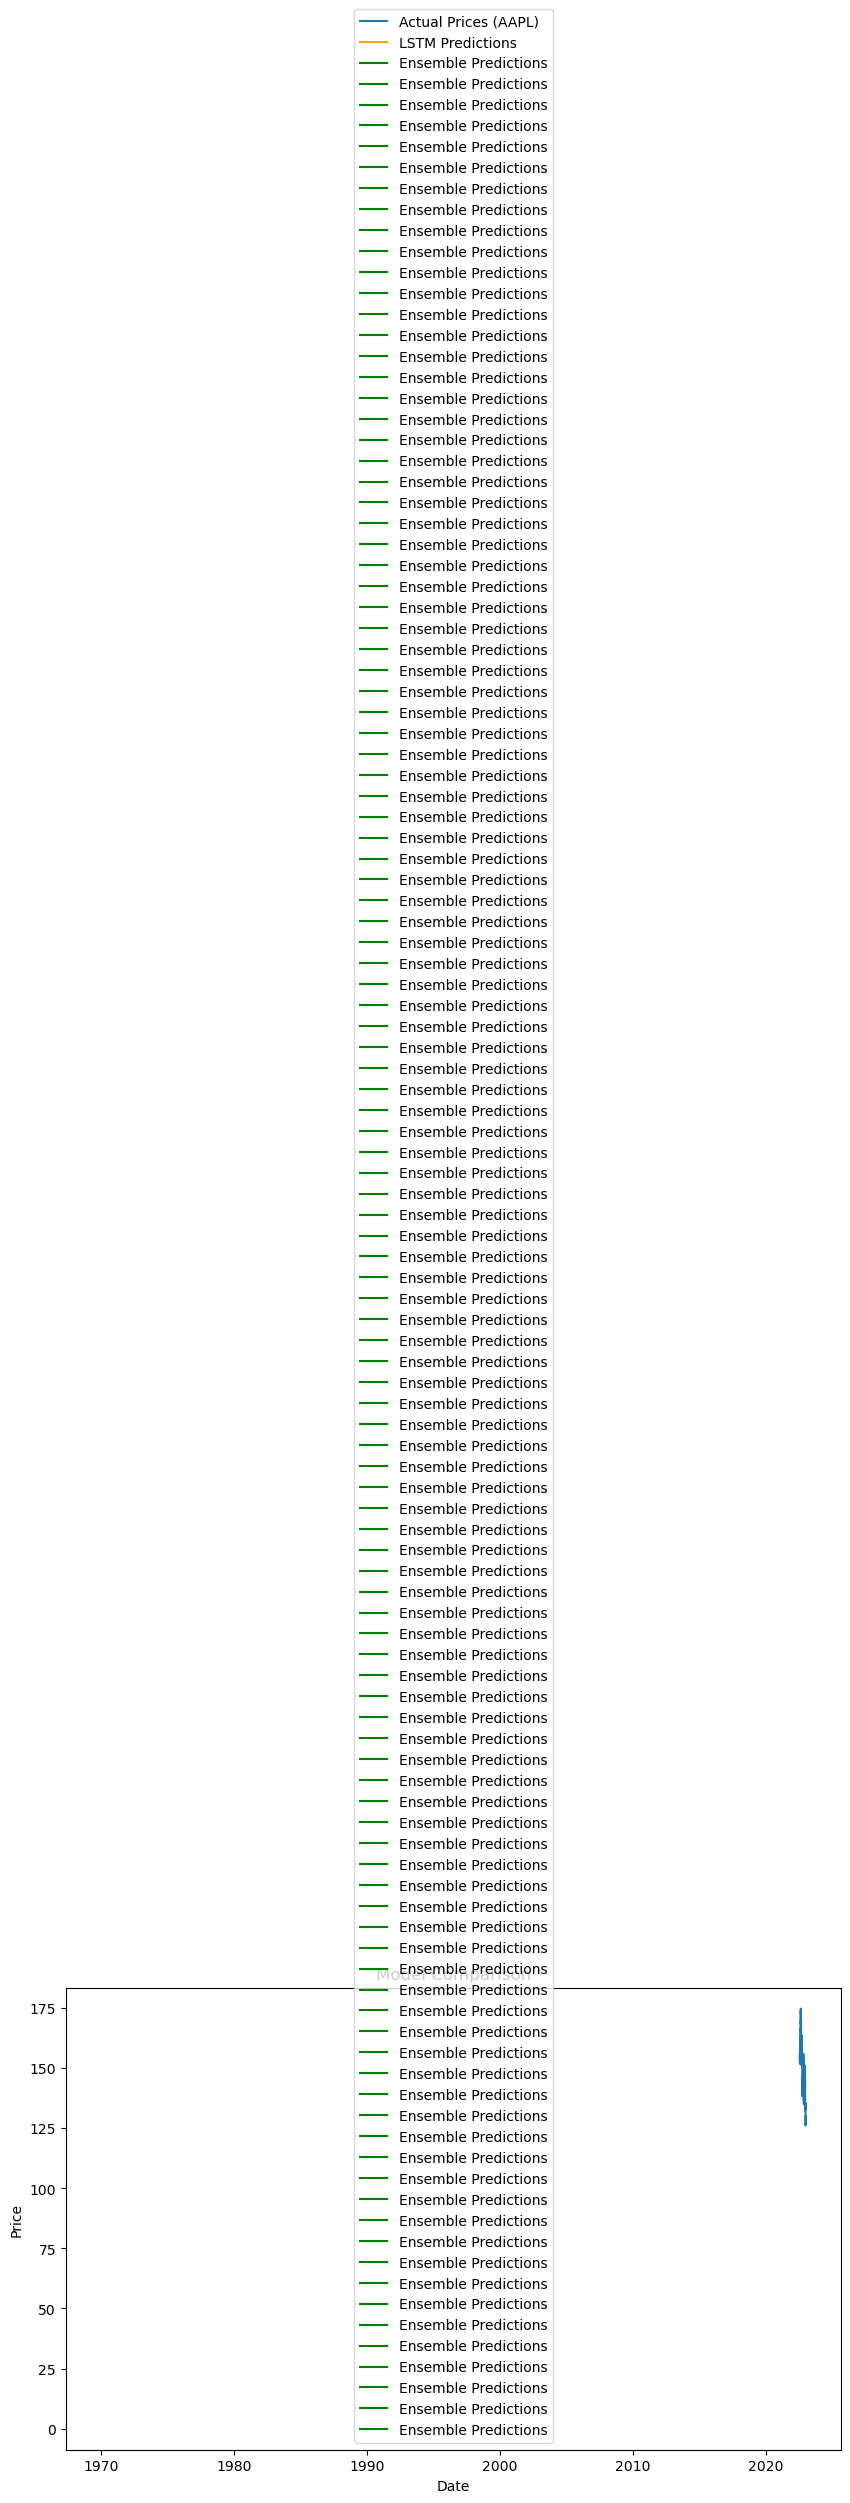

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot actual prices using the 'AAPL' column as an example
plt.plot(test_data['AAPL'], label='Actual Prices (AAPL)')

# Plot LSTM and ensemble predictions (assuming these arrays are defined and of the same length)
# Make sure that `predictions` and `ensemble_predictions` are aligned with the date range of `test_data`
plt.plot(predictions, color='orange', label='LSTM Predictions')
plt.plot(ensemble_predictions, color='green', label='Ensemble Predictions')

plt.title("Model Comparison")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Statistical Testing (ADF, KPSS Tests): Perform stationarity tests on the time series.

In [28]:
from statsmodels.tsa.stattools import adfuller, kpss
adf_test = adfuller(data['AAPL'])
kpss_test = kpss(data['AAPL'])
print("ADF Test:", adf_test)
print("KPSS Test:", kpss_test)

ADF Test: (-1.8877190853698453, 0.3378603120852182, 0, 726, {'1%': -3.4393893552577723, '5%': -2.8655292671104644, '10%': -2.5688943376666744}, 3458.039169797318)
KPSS Test: (3.0425846537638197, 0.01, 17, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/var/folders/_9/12tkftqn7lg31ymjdhtwgts00000gn/T/ipykernel_87034/3956611176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(data['AAPL'])


Economic Event Impact Analysis: Analyze the impact of major events (e.g., COVID-19) on stock prices.

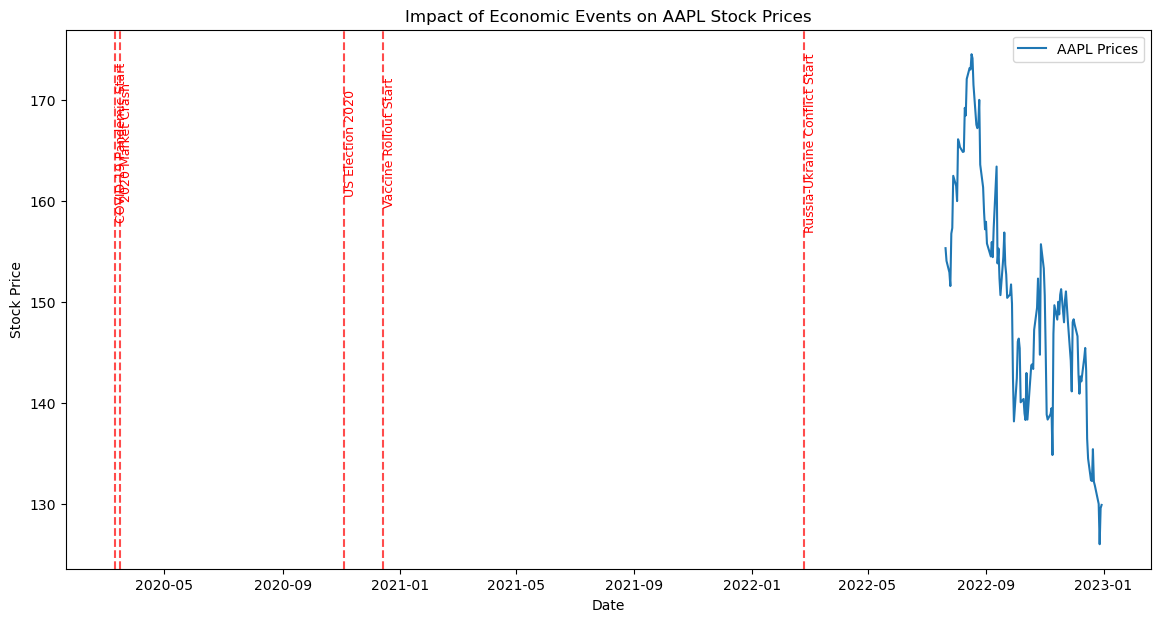

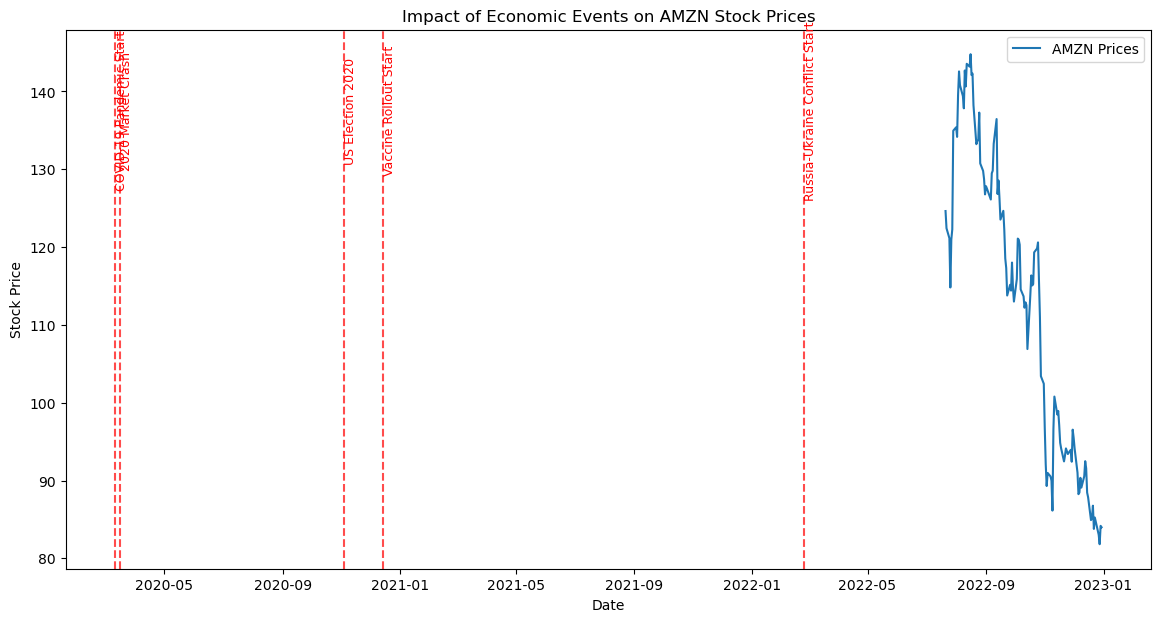

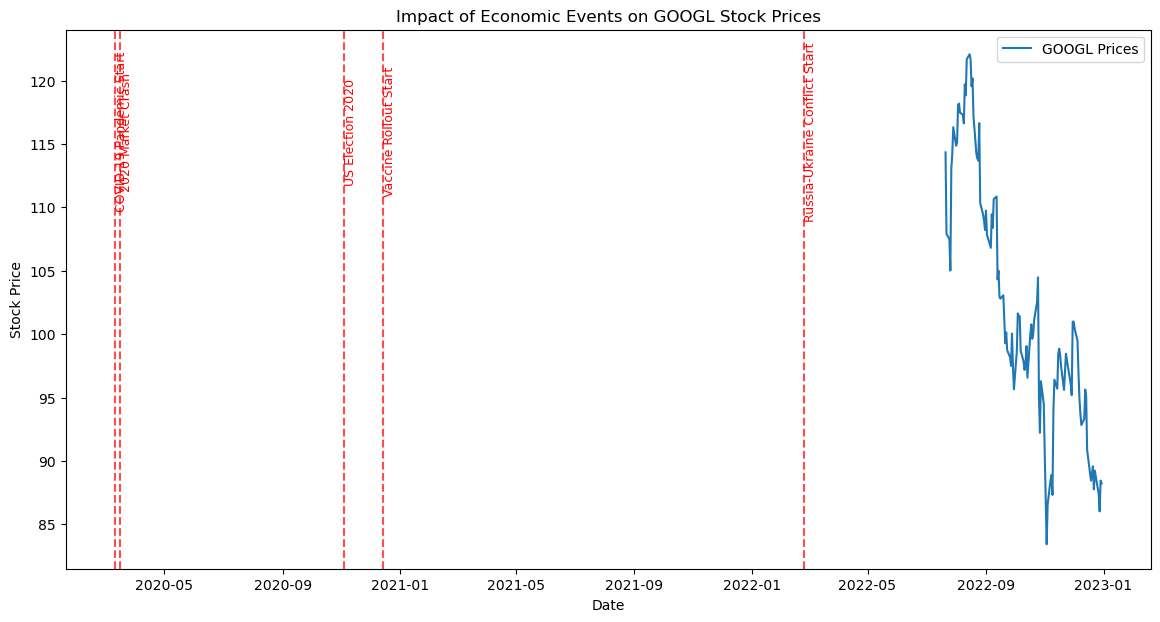

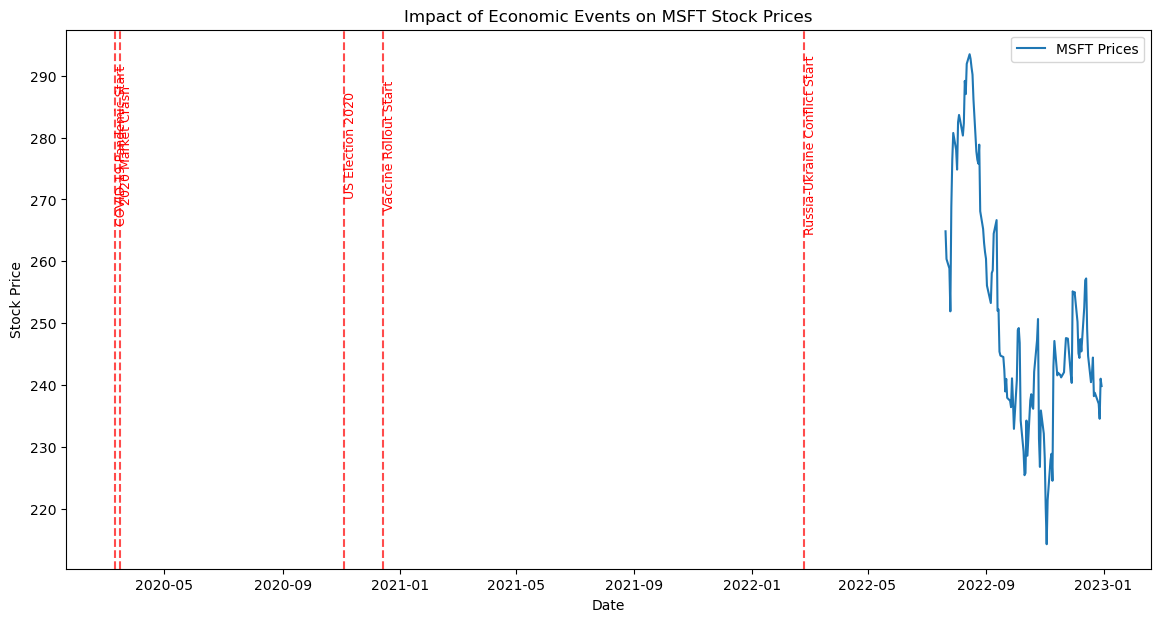

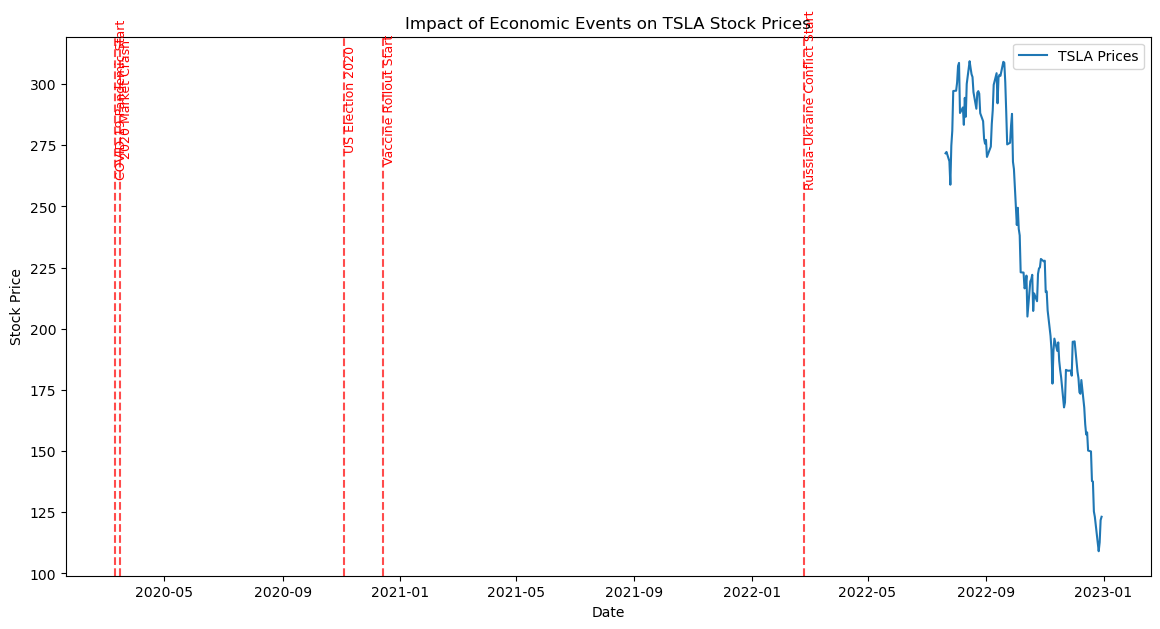

In [29]:
import matplotlib.pyplot as plt

# Define key economic events and their dates
economic_events = {
    'COVID-19 Pandemic Start': '2020-03-11',  # WHO declared COVID-19 a pandemic
    '2020 Market Crash': '2020-03-16',  # Major drop in stock prices due to COVID-19
    'US Election 2020': '2020-11-03',  # US Presidential Election
    'Vaccine Rollout Start': '2020-12-14',  # First COVID-19 vaccine administered in the US
    'Russia-Ukraine Conflict Start': '2022-02-24'  # Start of Russia-Ukraine conflict
}

# List of stock tickers to analyze (adjust according to your data)
stock_columns = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA']

# Loop through each stock and generate a plot
for stock in stock_columns:
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data[stock], label=f'{stock} Prices')

    # Annotate economic events on the plot
    for event, date in economic_events.items():
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(date), test_data[stock].max() * 0.95, event, 
                 rotation=90, verticalalignment='center', color='red', fontsize=9)

    # Plot title and labels
    plt.title(f"Impact of Economic Events on {stock} Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

Feature Importance Analysis: Identify which features are most predictive using SHAP or feature importance.

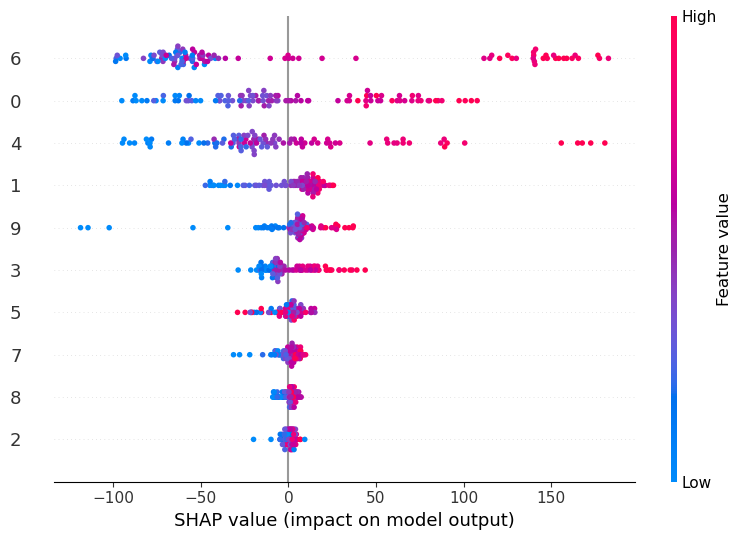

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Create a simple dataset and model for testing
X_test_simple, y_test_simple = make_regression(n_samples=100, n_features=10, random_state=42)
simple_model = RandomForestRegressor()
simple_model.fit(X_test_simple, y_test_simple)

# Use SHAP with the simple model
try:
    explainer = shap.TreeExplainer(simple_model)
    shap_values = explainer.shap_values(X_test_simple)
    shap.summary_plot(shap_values, features=pd.DataFrame(X_test_simple))
except Exception as e:
    print("TreeExplainer with simple model encountered an error:", e)


Dimensionality Reduction (PCA): Use PCA to reduce feature dimensionality and visualize.

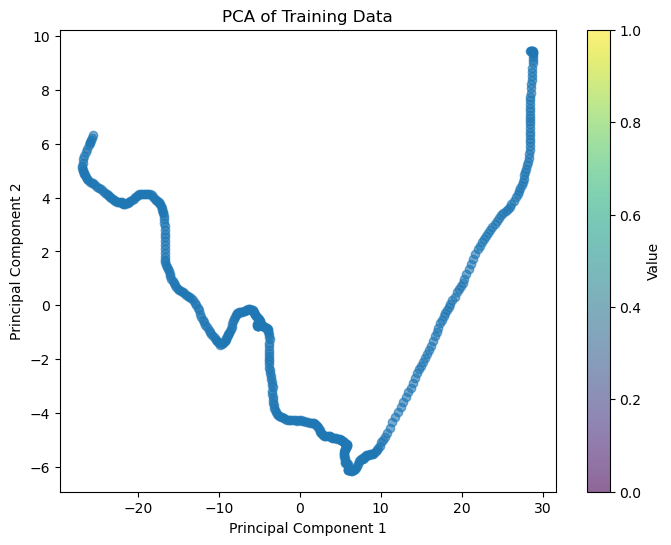

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Example 3D data structure: (samples, timesteps, features)
# Here, we're assuming X_train is a 3D array with shape (samples, timesteps, features)
# Flatten the data to 2D: (samples, timesteps * features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Standardize the reshaped data
scaled_data = StandardScaler().fit_transform(X_train_reshaped)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Training Data")
plt.colorbar(label='Value')
plt.show()


Anomaly Detection: Detect unusual price movements or volume spikes using Isolation Forest.

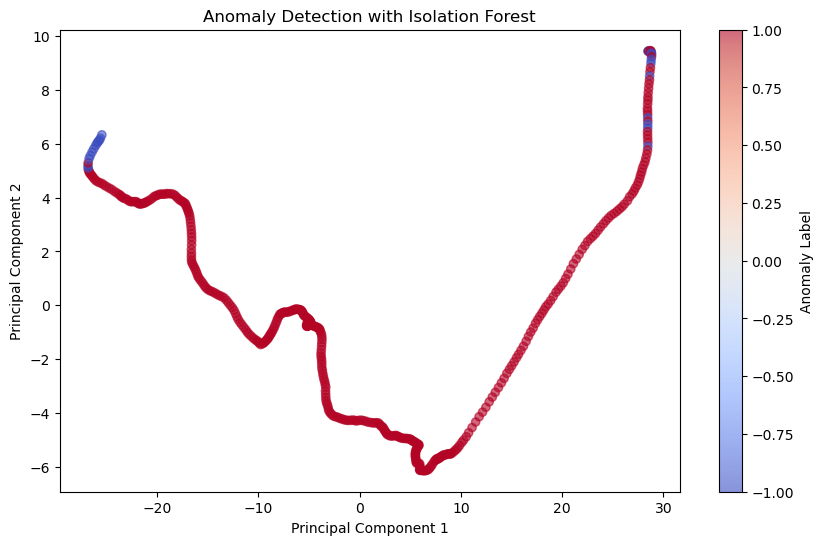

Number of anomalies detected: 24


In [32]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Set contamination level and fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_train_reshaped)  # Use reshaped data if needed

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=anomaly_labels, cmap='coolwarm', alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Anomaly Detection with Isolation Forest")
plt.colorbar(label="Anomaly Label")
plt.show()

# Print the number of anomalies detected
print(f"Number of anomalies detected: {(anomaly_labels == -1).sum()}")


Risk Analysis (VaR Calculation): Calculate Value at Risk (VaR) for stocks.

In [33]:
import numpy as np
import pandas as pd

# Calculate daily returns for AAPL
returns = data['AAPL'].pct_change().dropna()  # Replace 'AAPL' with other stock names as needed

# Set the confidence level, e.g., 95%
confidence_level = 0.05
VaR = np.percentile(returns, confidence_level * 100)  # Calculate VaR at 95% confidence

print(f"Value at Risk (VaR) for AAPL at 95% confidence level: {VaR:.2%}")


Value at Risk (VaR) for AAPL at 95% confidence level: -3.49%


In [34]:
# Loop through each stock column to calculate VaR
confidence_level = 0.05
for stock in ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA']:
    returns = data[stock].pct_change().dropna()
    VaR = np.percentile(returns, confidence_level * 100)
    print(f"Value at Risk (VaR) for {stock} at 95% confidence level: {VaR:.2%}")


Value at Risk (VaR) for AAPL at 95% confidence level: -3.49%
Value at Risk (VaR) for AMZN at 95% confidence level: -3.74%
Value at Risk (VaR) for GOOGL at 95% confidence level: -3.63%
Value at Risk (VaR) for MSFT at 95% confidence level: -3.50%
Value at Risk (VaR) for TSLA at 95% confidence level: -6.81%


Backtesting of Models: Test model predictions with historical data.

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'data' is the DataFrame and 'AAPL' is the target stock (use the actual column for your target)
# Prepare features (X) and target (y)
X = data.drop(columns=['AAPL'])  # Drop the target column from features
y = data['AAPL']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (RandomForestRegressor is an example; replace with your model if different)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Backtesting: Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Backtesting Results: MAE = {mae:.2f}, RMSE = {rmse:.2f}")


Backtesting Results: MAE = 1.39, RMSE = 1.79


Final Model Deployment: Deploy the final model as a web app using Flask or Streamlit.

In [42]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming 'data' is your DataFrame and 'AAPL' is the target variable (replace with your target column)
X = data.drop(columns=['AAPL'])  # Drop target column to get features
y = data['AAPL']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a new model (using RandomForestRegressor as an example)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Save the model to a file
joblib.dump(model, "final_model.joblib")
print("Model saved as 'final_model.joblib'")


Model saved as 'final_model.joblib'


In [43]:
# Load the model from the saved file
model = joblib.load("final_model.joblib")
print("Model loaded successfully.")

# Make predictions on the test set and evaluate
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Backtesting Results: MAE = {mae:.2f}, RMSE = {rmse:.2f}")


Model loaded successfully.
Backtesting Results: MAE = 1.39, RMSE = 1.79


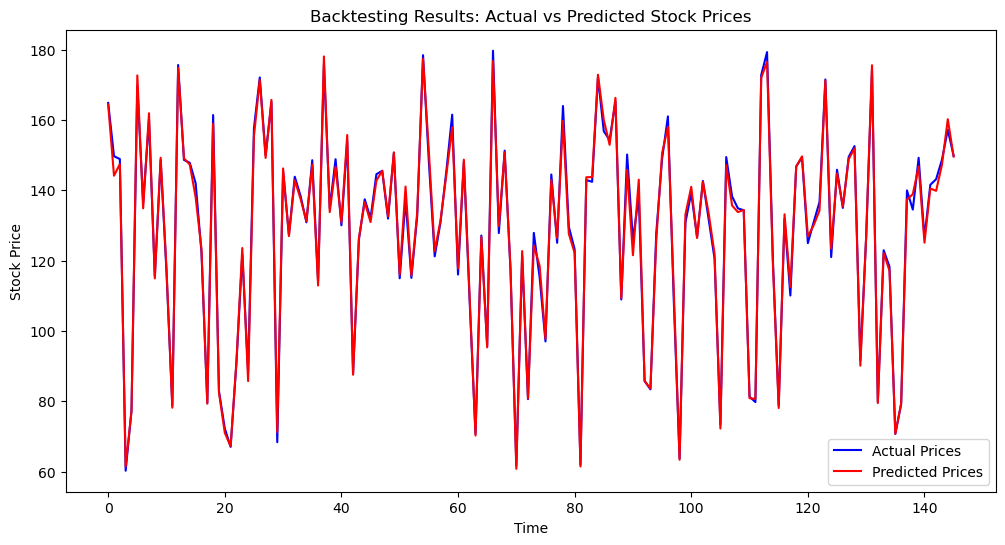

In [44]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values to visualize backtesting performance
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", color="red")
plt.title("Backtesting Results: Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


Final Model Deployment: Deploy the final model as a web app using Flask or Streamlit.

In [46]:
import streamlit as st
import joblib
import pandas as pd
import numpy as np

# Load the trained model
model = joblib.load("final_model.joblib")

# Streamlit app layout
st.title("Stock Price Prediction App")

# Input for user to enter stock features (replace with actual features you have)
st.write("Enter stock features:")
feature_values = {}
for feature in X_test.columns:
    feature_values[feature] = st.number_input(f"Enter value for {feature}", value=float(X_test[feature].mean()))

# Predict and display results
if st.button("Predict"):
    # Prepare the input data in the format expected by the model
    input_data = pd.DataFrame([feature_values])
    prediction = model.predict(input_data)
    st.write(f"Predicted Stock Price: ${prediction[0]:.2f}")


2024-11-07 14:47:00.195 
  command:

    streamlit run /opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
